# Slab geometry
In this notebook, we calculate the bands of an infinite slab of SnTe for three different surfaces: [001], [110], [111], as the are supposed to be perpendicular to the mirror symmetry that protects these states. Eventually we want to evaluate for a thickness of 50 nm. These are the typical sizes that we grow in the lab. So for the [001] direction, this comes down to about 80 atoms, assuming a lattice constant of $a = 6,3268 \overset{\circ}{A}$.

In [1]:
import qsymm
import kwant
import numpy as np
import sympy
from IPython.display import display
from IPython.display import Math
import matplotlib.pyplot as plt
import kwant.qsymm
import kwant.builder
import scipy.sparse.linalg as sla
from numpy import linalg as LA

C:\Users\pimke\anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [2]:
ham_mass = ("-m * kron(sigma_z, eye(3))")
ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
ham_nnn = ("2*t_Sn*kron(sigma_z, Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +")"
ham_ = "kron(" + ham + ", eye(2))"
soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
Ham = "(" + ham_ +" + " + soi +")"
H = qsymm.Model(Ham)
H.tosympy(nsimplify=True)

Matrix([
[e**(I*k_x)*e**(I*k_y)*t_Sn/2 + e**(I*k_x)*e**(I*k_z)*t_Sn/2 + e**(I*k_x)*e**(-I*k_z)*t_Sn/2 + e**(I*k_x)*e**(-I*k_y)*t_Sn/2 + m_Sn + e**(-I*k_x)*e**(I*k_y)*t_Sn/2 + e**(-I*k_x)*e**(I*k_z)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_z)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_y)*t_Sn/2,                                                                                                                                                                                                                                                                    0,                                                                                                                          e**(I*k_x)*e**(I*k_y)*t_Sn/2 - e**(I*k_x)*e**(-I*k_y)*t_Sn/2 - I*lambda_Sn - e**(-I*k_x)*e**(I*k_y)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_y)*t_Sn/2,                                                                                                                                                                                                             

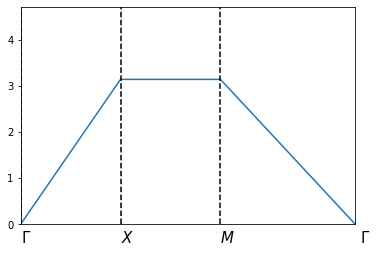

In [3]:
a = 1 # Normalized lattice spacing
stepsize = 20

G_k = [np.pi/a*np.array([0, 0]), '$\\Gamma$']
X_k = [np.pi/a*np.array([1, 0]), '$X$']
M_k = [np.pi/a*np.array([1, 1]), '$M$']
G_k2= [np.pi/a*np.array([2, 0]), '$\\Gamma$']

def HSP(hsp, stepsize):
    
    kx_array = []
    ky_array = []
    
    norm = 0
    hsp_k = 0
    hsp_list = [0]
    
    for i in range(len(hsp) - 1):
        norm = np.linalg.norm(hsp[1][0] - hsp[0][0])
        norm_new = np.linalg.norm(hsp[i + 1][0] - hsp[i][0])
        if i == len(hsp) - 2:
            endpoint = True # Take into account k on last high symmetry point
        else:
            endpoint = False
        kx_new = np.linspace(hsp[i][0][0], hsp[i + 1][0][0], int(stepsize*norm_new/norm), endpoint = endpoint)
        ky_new = np.linspace(hsp[i][0][1], hsp[i + 1][0][1], int(stepsize*norm_new/norm), endpoint = endpoint)
        kx_array = np.hstack([kx_array, kx_new])
        ky_array = np.hstack([ky_array, ky_new])

        hsp_k_new = len(kx_new)
        hsp_k += hsp_k_new
        hsp_list.append(hsp_k)
        
        k_array = np.linspace(0, len(kx_array) - 1, len(kx_array))
    return kx_array, ky_array, k_array, hsp_list

hsp = G_k, X_k, M_k, G_k # Sequence of high symmetry points

kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize)
#print(kx_array)

_list = [0, 2*np.pi]
plt.plot(k_array, kx_array)
plt.ylim(0, 3*np.pi/2)
plt.xticks([])
plt.xlim(0, max(k_array))
for i in range(len(hsp)):
    hsp_point = np.ones(2)*hsp_list[i]
    plt.plot(hsp_point, _list, linestyle = 'dashed', color = 'black')
    plt.text(hsp_list[i], -0.4, hsp[i][1], fontsize = 15)
plt.show()

## Slab confined in the [001] direction and plotted along single high symmetry line

In [4]:
def Slab001(H, param):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1])))
    
    
    #kwant.plot(template, site_size = 0.1, hop_lw = 0.05)
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= z < H
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, -1, 0]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()
    
    kwant.plotter.spectrum(syst, ('k_x', np.linspace(-np.pi, np.pi, 51)),
                    params = param,
                      fig_size = (8, 8));
    
    return syst

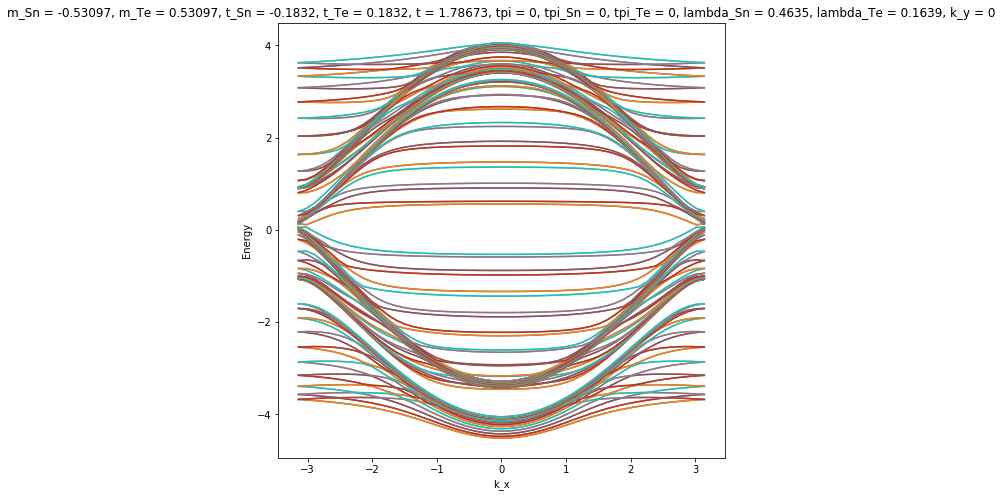

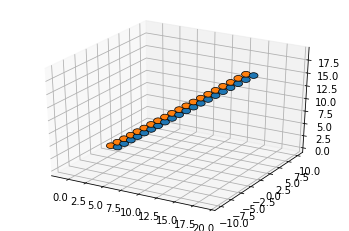

Wall time: 2.95 s


In [125]:
%%time

param_Hsieh = dict(
    m_Sn = -1.65, 
    m_Te = 1.65,
    t = 0.9, 
    t_Sn = -0.5, 
    t_Te = 0.5,
    tpi = 0,
    tpi_Sn = 0,
    tpi_Te = 0,
    lambda_Sn = 0.3, 
    lambda_Te = 0.3, 
    k_y = 0)

param_Pim = dict(
    m_Sn = -1.08837,
    m_Te = 0.677069,
    t_Sn = -0.25263,
    t_Te = -0.13034,
    t = 1.328532,
    tpi = 0.28035,
    tpi_Sn = -0.555951,
    tpi_Te = -0.214956,
    lambda_Sn = 0.307393,
    lambda_Te = 0.144278,
    k_y = 0)

param_Pim_red = dict(
    m_Sn = -0.53097,
    m_Te = 0.53097,
    t_Sn = -0.1832,
    t_Te = 0.1832,
    t = 1.78673,
    tpi = 0,
    tpi_Sn = 0,
    tpi_Te = 0,
    lambda_Sn = 0.4635,
    lambda_Te = 0.1639,
    k_y = 0)

param_Daniel = dict(
    m_Sn = -0.7896,
    m_Te = 0.9907,
    t_Sn = -0.2149,
    t_Te = -0.0183,
    t = 2.0803,
    tpi = 0,
    tpi_Sn = 0,
    tpi_Te = 0,
    lambda_Sn = 0.2370,
    lambda_Te = 0.2687,
    k_y = 0)

param_test = dict(
    m_Sn = -2,
    m_Te = 2,
    t = 0.9, 
    t_Sn = 0, 
    t_Te = 0,
    tpi = 0,
    tpi_Sn = 0,
    tpi_Te = 0,
    lambda_Sn = 0.3, 
    lambda_Te = 0.3, 
    k_y = 0)

kwant.plot(Slab001(H = 20, param = param_Pim_red))
plt.show()

## Slab confined in the [001] direction and plotted along HSP: $\Gamma, X, M, \Gamma$
For a simulation of a 50 nm thick slab, we need 80 atoms.

In [18]:
def Slab001(H, hsp):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1])))
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= z < H
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, -1, 0]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()

    kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)
        
    matrixsizeslab = H*12 # Size of basis: 2 atoms per unit cell, 6 orbitals per atom, H atoms thick in slab
    energiesslab = np.zeros((matrixsizeslab, len(kx_array)))
    for i in range(len(kx_array)):
        param_Hsieh = dict(
        m_Sn = -1.65, 
        m_Te = 1.65,
        t = 0.9, 
        t_Sn = -0.5, 
        t_Te = 0.5,
        tpi = 0,
        tpi_Sn = 0,
        tpi_Te = 0,
        lambda_Sn = 0.3, 
        lambda_Te = 0.3,
        k_x = kx_array[i],
        k_y = ky_array[i])
        for j in range(matrixsizeslab):
            energiesslab[j][i] = LA.eigvalsh(syst.hamiltonian_submatrix(params = param_Hsieh))[j]
            print('\r' + str(int(j/matrixsizeslab*100))+'% completed of a single k and ' + str((i/len(kx_array)*100))+'% completed of total k-path',end='')
            
    return energiesslab

In [22]:
def Slab001(H, hsp):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1])))
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= z < H
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, -1, 0]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()

    kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)
        
    matrixsizeslab = H*12 # Size of basis: 2 atoms per unit cell, 6 orbitals per atom, H atoms thick in slab
    k = 20 # Number of bands to take into account
    energiesslab = np.zeros((matrixsizeslab, len(kx_array)))
    for i in range(len(kx_array)):
        param_Hsieh = dict(
        m_Sn = -1.65, 
        m_Te = 1.65,
        t = 0.9, 
        t_Sn = -0.5, 
        t_Te = 0.5,
        tpi = 0,
        tpi_Sn = 0,
        tpi_Te = 0,
        lambda_Sn = 0.3, 
        lambda_Te = 0.3,
        k_x = kx_array[i],
        k_y = ky_array[i])
        for j in range(k):
            H = syst.hamiltonian_submatrix(params = param_Hsieh, sparse = True)
            energiesslab[j][i] = sla.eigsh(H, k = k ,sigma = 0, return_eigenvectors = False)[j]
            print('\r' + str(int(j/k*100))+'% completed of a single k and ' + str((i/len(kx_array)*100))+'% completed of total k-path',end='')
            
    return energiesslab

In [32]:
%%time

G_k = [np.pi/a*np.array([0, 0]), '$\\Gamma$']
X_k = [np.pi/a*np.array([1, 0]), '$X$']
M_k = [np.pi/a*np.array([1, 1]), '$M$']

GX_k = [np.pi/a*np.array([1/2, 0]), '$\\Gamma \\leftarrow$']
X_k = [np.pi/a*np.array([1, 0]), '$X$']
XM_k = [np.pi/a*np.array([1, 1/2]), '$\\rightarrow M$']

H = 20 # Number of atoms thick
hsp = (GX_k, X_k, XM_k)

kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)
energiesslab001 = Slab001(H, hsp)
matrixsizeslab = H*12 # Size of basis: 2 atoms per unit cell, 6 orbitals per atom, H atoms thick in slab

95% completed of a single k and 99.5% completed of total k-pathWall time: 1min 22s


In [174]:
#np.savetxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Pimred_slab_001_80_atoms', energiesslab001)

#energiesslab001 = np.loadtxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Pimred_slab_001_80_atoms')

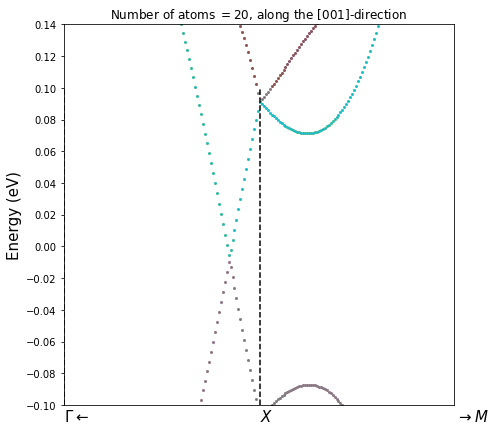

In [42]:
minimum = -.1
maximum = .1

energiesslab001 = np.ma.masked_equal(energiesslab001, 0) # Mask all zero values. Keeps the dimensions intact.

# Generate the plot
fig = plt.figure(figsize = (7,7))

for i in range(matrixsizeslab):
    plt.scatter(k_array, energiesslab001[i], s = 3)
plt.ylabel(r"Energy (eV)", fontsize = 15)
plt.xlim(0, max(k_array))
plt.ylim(minimum, maximum, 0.2)
plt.xticks([])
plt.yticks(np.arange(minimum, maximum + 0.05, (maximum - minimum)/10))
for i in range(len(hsp)):
    hsp_point = np.ones(2)*hsp_list[i]
    plt.plot(hsp_point, [minimum, maximum], linestyle = 'dashed', color = 'black')
    plt.text(hsp_list[i], minimum - 0.1*maximum, hsp[i][1], fontsize = 15)
    plt.title(
    r'Number of atoms $= %g$, along the [001]-direction' % (
        H), fontsize = 12)
#plt.savefig('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Thesis/Figures/Python/Slab_geometry/Pimred_001_80.png', bbox_inches = 'tight')
plt.show()

In [40]:
print(energiesslab001.shape)
energiesslab001nozeros = np.ma.masked_equal(energiesslab001,0)
print(energiesslab001nozeros.shape)

(240, 200)
(240, 200)


### Slab confined in the [001] direction. sla.eigsh method

In [ ]:
def ndlinspace(start, end, N):
    start, end = np.array(start), np.array(end)
    return np.array([start + (end - start) * x
                     for x in np.linspace(0, 1, N)])

## Slab confined in the [110] direction
For a simulation of 50 nm, we need 56 atom thick slab.

In [50]:
def Slab110(H, hsp):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1])))
    
    #kwant.plot(template, site_size = 0.1, hop_lw = 0.05)
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= x + y < H  
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([-1, 1, 0], [0, 0, 2]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()
    
    kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)
        
    matrixsizeslab = H*12 # Size of basis: 2 atoms per unit cell, 6 orbitals per atom, H atoms thick in slab
    energiesslab = np.zeros((matrixsizeslab, len(kx_array)))
    for i in range(len(kx_array)):
        param_Hsieh = dict(
        m_Sn = -1.65, 
        m_Te = 1.65,
        t = 0.9, 
        t_Sn = -0.5, 
        t_Te = 0.5,
        tpi = 0,
        tpi_Sn = 0,
        tpi_Te = 0,
        lambda_Sn = 0.3, 
        lambda_Te = 0.3,
        k_x = kx_array[i],
        k_y = ky_array[i])
        for j in range(matrixsizeslab):
            energiesslab[j][i] = LA.eigvalsh(syst.hamiltonian_submatrix(params = param_Hsieh))[j]
            print('\r' + str(int(j/matrixsizeslab*100))+'% completed of a single k and ' + str((i/len(kx_array)*100))+'% completed of total k-path',end='')
            
    return energiesslab

In [52]:
def Slab110(H, hsp):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1])))
    
    #kwant.plot(template, site_size = 0.1, hop_lw = 0.05)
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= x + y < H  
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([-1, 1, 0], [0, 0, 2]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()
    
    kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)
        
    matrixsizeslab = H*12 # Size of basis: 2 atoms per unit cell, 6 orbitals per atom, H atoms thick in slab
    k = 20 # Number of bands to take into account
    energiesslab = np.zeros((matrixsizeslab, len(kx_array)))
    for i in range(len(kx_array)):
        param_Hsieh = dict(
        m_Sn = -1.65, 
        m_Te = 1.65,
        t = 0.9, 
        t_Sn = -0.5, 
        t_Te = 0.5,
        tpi = 0,
        tpi_Sn = 0,
        tpi_Te = 0,
        lambda_Sn = 0.3, 
        lambda_Te = 0.3,
        k_x = kx_array[i],
        k_y = ky_array[i])
        for j in range(k):
            H = syst.hamiltonian_submatrix(params = param_Hsieh, sparse = True)
            energiesslab[j][i] = sla.eigsh(H, k = k ,sigma = 0, return_eigenvectors = False)[j]
            print('\r' + str(int(j/k*100))+'% completed of a single k and ' + str((i/len(kx_array)*100))+'% completed of total k-path',end='')
            
    return energiesslab

In [53]:
%%time

G_k = [np.pi/a*np.array([0, 0]), '$\\Gamma$']  
X_k = [np.pi/a*np.array([1, 0]), '$X$']
Y_k = [np.pi/a*np.array([0, 1]), '$Y$']
M_k = [np.pi/a*np.array([1, 1]), '$M$']
GY_k = [np.pi/a*np.array([0, 0.5]), '$\\Gamma \\leftarrow$']
MG_k = [np.pi/a*np.array([0.5, 0.5]), '$\\rightarrow \\Gamma$']
M2_k = [np.pi/a*np.array([1, -1]), '$M$']

H = 56 # Number of atoms thick
#hsp = (GY_k, Y_k, M_k, MG_k)
hsp = (GY_k, Y_k)
#hsp = (M_k, X_k, M2_k)

energiesslab110 = Slab110(H, hsp)
matrixsizeslab = H*12 # Size of basis: 2 atoms per unit cell, 6 orbitals per atom, H atoms thick in slab

95% completed of a single k and 99.0% completed of total k-pathWall time: 2min 29s


In [6]:
#np.savetxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Pimred_slab_110_56_atoms', energiesslab110)

#energiesslab110 = np.loadtxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Hsieh_slab_110_56_atoms')

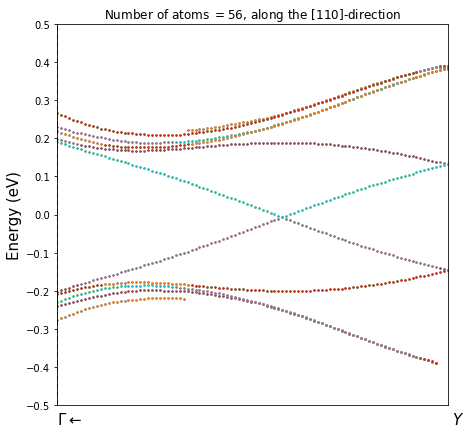

In [55]:
minimum = -.5
maximum = .5
kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)

energiesslab110 = np.ma.masked_equal(energiesslab110, 0) # Mask all zero values. Keeps the dimensions intact.

# Generate the plot
fig = plt.figure(figsize = (7,7))

for i in range(matrixsizeslab):
    plt.scatter(k_array, energiesslab110[i], s= 2)
plt.ylabel(r"Energy (eV)", fontsize = 15)
plt.xlim(0, max(k_array))
plt.ylim(minimum, maximum, 0.2)
plt.xticks([])
plt.yticks(np.arange(minimum, maximum + 0.05, (maximum - minimum)/10))
for i in range(len(hsp)):
    hsp_point = np.ones(2)*hsp_list[i]
    plt.plot(hsp_point, [minimum, maximum], linestyle = 'dashed', color = 'black')
    plt.text(hsp_list[i], minimum - 0.1*maximum, hsp[i][1], fontsize = 15)
plt.title(
    r'Number of atoms $= %g$, along the [110]-direction' % (
        H), fontsize = 12)
#plt.savefig('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Thesis/Figures/Python/Slab_geometry/Hsieh_110_56.png', bbox_inches = 'tight')
plt.show()

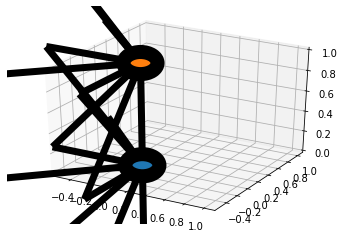

99% completed

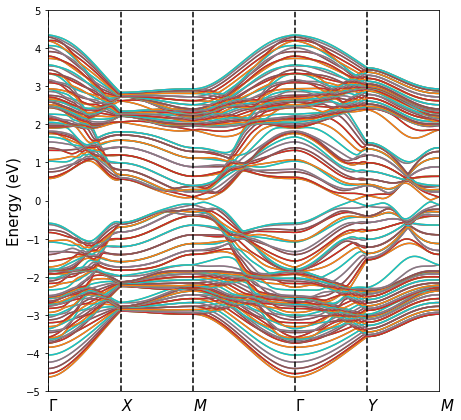

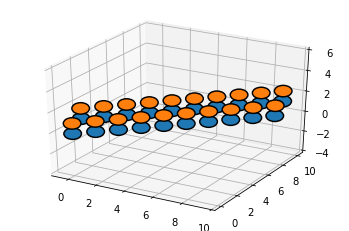

Wall time: 13min 2s


In [34]:
%%time

# These are in the coordinate system of the reciprocal vectors. So k_x along [-110] and k_y along [002]
G_k = [np.pi/a*np.array([0, 0]), '$\\Gamma$']  
X_k = [np.pi/a*np.array([1, 0]), '$X$']
Y_k = [np.pi/a*np.array([0, 1]), '$Y$']
M_k = [np.pi/a*np.array([1, 1]), '$M$']


plot = kwant.plot(Slab110(H = 20, hsp = (G_k, X_k, M_k, G_k, Y_k, M_k)))
plt.show()

In [51]:
def Slab110(H, param):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1])))
    
    
    #kwant.plot(template, site_size = 0.1, hop_lw = 0.05)
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= x + y < H  
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([-1, 1, 0], [0, 0, 2]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()
    
    kwant.plotter.spectrum(syst, ('k_x', np.linspace(-np.pi, np.pi, 101)),
                    params = param,
                      fig_size = (8, 8));
    
    return syst

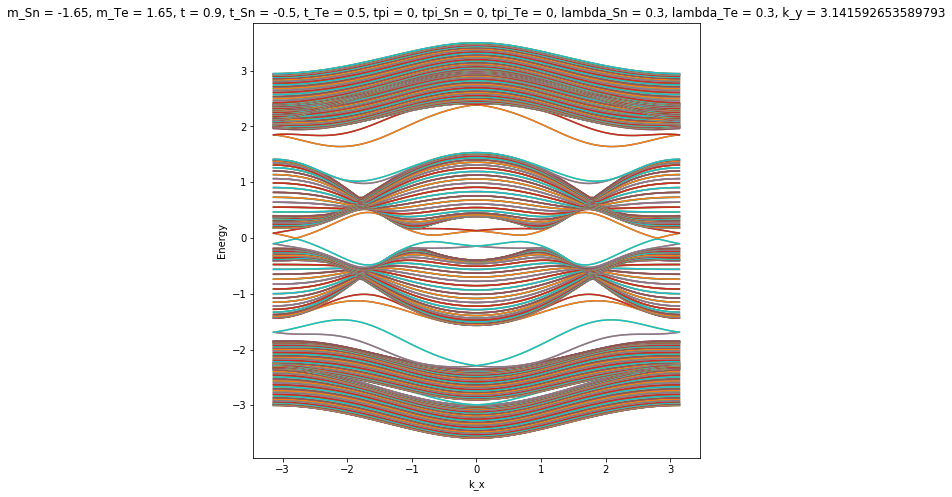

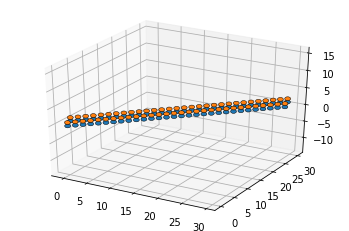

Wall time: 10 s


In [54]:
%%time

param_test = dict(
    m_Sn = -1.65, 
    m_Te = 1.65,
    t = 0.9, 
    t_Sn = -0.5, 
    t_Te = 0.5,
    tpi = 0,
    tpi_Sn = 0,
    tpi_Te = 0,
    lambda_Sn = 0.3, 
    lambda_Te = 0.3, 
    k_y = np.pi)

kwant.plot(Slab110(H = 60, param = param_test))
plt.show()

## Slab confined in the [111] direction
For a simulation of 50 nm, we need a 45 or 46 atom thick slab.

In [178]:
def Slab111(H, hsp):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 1], [0, 0, 0]))) # For different termination, exchange the 0 and 1
    
    #kwant.plot(template, site_size = 0.1, hop_lw = 0.05)
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= x + y + z < H  
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([-1, 0, 1], [0, 1, -1]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()
    
    kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)
        
    matrixsizeslab = H*6 # Size of basis: 2 atoms per unit cell, 6 orbitals per atom, H atoms thick in slab
    energiesslab = np.zeros((matrixsizeslab, len(kx_array)))
    for i in range(len(kx_array)):
        param_Pim_red = dict(
        m_Sn = -0.53097,
        m_Te = 0.53097,
        t_Sn = -0.1832,
        t_Te = 0.1832,
        t = 1.78673,
        tpi = 0,
        tpi_Sn = 0,
        tpi_Te = 0,
        lambda_Sn = 0.4635,
        lambda_Te = 0.1639,
        k_x = kx_array[i],
        k_y = ky_array[i])
        for j in range(matrixsizeslab):
            energiesslab[j][i] = LA.eigvalsh(syst.hamiltonian_submatrix(params = param_Pim_red))[j]
            print('\r' + str(int(j/matrixsizeslab*100))+'% completed of a single k and ' + str((i/len(kx_array)*100))+'% completed of total k-path',end='')
            
    return energiesslab

In [187]:
%%time

G_k = [np.pi/a*np.array([0, 0]), '$\\Gamma$']  
M_k = [np.pi/a*np.array([0, 1]), '$M$']
K_k = [np.pi/a*np.array([2/3, 2/3]), '$K$']
M_k2 = [np.pi/a*np.array([1, 0]), '$M$']
#G_k2 = [np.pi/a*np.array([2, 2]), '$\\Gamma_2$'] 

H = 91 # Number of atoms thick
hsp = (K_k, G_k, M_k, K_k)

#energiesslab111 = Slab111(H, hsp)
matrixsizeslab = H*6 # Size of basis: 1 atom per unit cell, 6 orbitals per atom, H atoms thick in slab

Wall time: 0 ns


In [188]:
#np.savetxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Pimred_slab_111_91_atoms', energiesslab111)

energiesslab111 = np.loadtxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Pimred_slab_111_91_atoms')

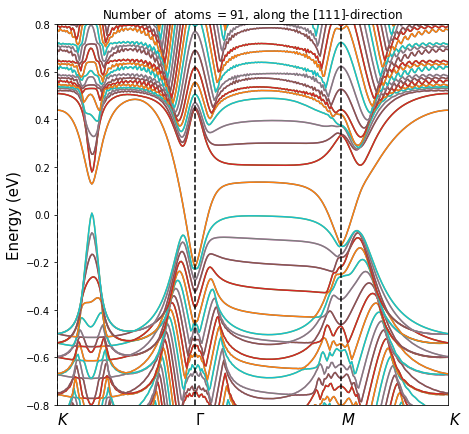

In [189]:
minimum = -0.8
maximum = 0.8
kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)

# Generate the plot
fig = plt.figure(figsize = (7,7))

for i in range(matrixsizeslab):
    plt.plot(k_array, energiesslab111[i])
plt.ylabel(r"Energy (eV)", fontsize = 15)
plt.xlim(0, max(k_array))
plt.ylim(minimum, maximum, 0.2)
plt.xticks([])
plt.yticks(np.arange(minimum, maximum + 0.05, (maximum - minimum)/8))
for i in range(len(hsp)):
    hsp_point = np.ones(2)*hsp_list[i]
    plt.plot(hsp_point, [minimum, maximum], linestyle = 'dashed', color = 'black')
    plt.text(hsp_list[i], minimum - 0.1*maximum, hsp[i][1], fontsize = 15)
plt.title(
    r'Number of  atoms $= %g$, along the [111]-direction' % (
        H), fontsize = 12)
#plt.savefig('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Thesis/Figures/Python/Slab_geometry/Pimred_111_91.png', bbox_inches = 'tight')
plt.show()

In [128]:
#H = 21 # Number of atoms thick
hsp = (K_k, G_k, M_k, K_k)
kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)
matrixsizeslab20 = 20*6
matrixsizeslab21 = 21*6

energiesslab111_20 = np.loadtxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Hsieh_slab_111_20_atoms')
energiesslab111_21 = np.loadtxt('C:/Users/pimke/Documents/TUe/2020-2021/Master Thesis/Numeriek/Python/Geometry/Data/Hsieh_slab_111_21_atoms')
print(energiesslab111_20.shape)
print(matrixsizeslab20)
print(len(k_array))

(120, 285)
120
285


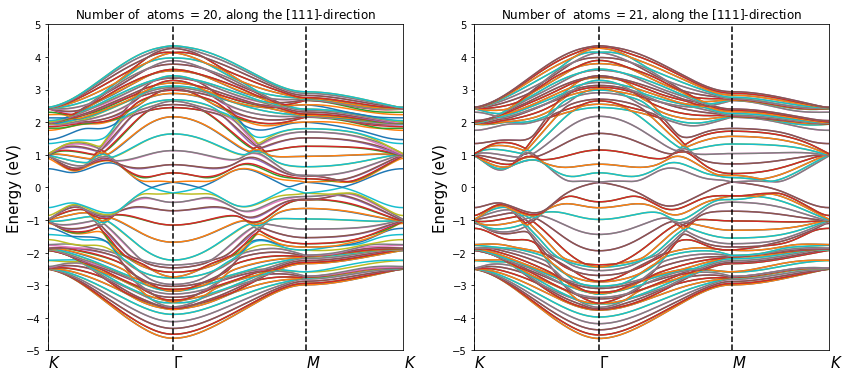

In [132]:
minimum = -5
maximum = 5
kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize = 100)

H = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

for i in range(matrixsizeslab20):
    ax1.plot(k_array, energiesslab111_20[i])
ax1.set_ylabel(r"Energy (eV)", fontsize = 15)
ax1.set_xlim(0, max(k_array))
ax1.set_ylim(minimum, maximum, 0.2)
ax1.set_xticks([])
ax1.set_yticks(np.arange(minimum, maximum + 0.05, (maximum - minimum)/10))
for i in range(len(hsp)):
    hsp_point = np.ones(2)*hsp_list[i]
    ax1.plot(hsp_point, [minimum, maximum], linestyle = 'dashed', color = 'black')
    ax1.text(hsp_list[i], minimum - 0.1*maximum, hsp[i][1], fontsize = 15)
ax1.set_title(
    r'Number of  atoms $= %g$, along the [111]-direction' % (
        H), fontsize = 12)

H = 21

for i in range(matrixsizeslab21):
    ax2.plot(k_array, energiesslab111_21[i])
ax2.set_ylabel(r"Energy (eV)", fontsize = 15)
ax2.set_xlim(0, max(k_array))
ax2.set_ylim(minimum, maximum, 0.2)
ax2.set_xticks([])
ax2.set_yticks(np.arange(minimum, maximum + 0.05, (maximum - minimum)/10))
for i in range(len(hsp)):
    hsp_point = np.ones(2)*hsp_list[i]
    ax2.plot(hsp_point, [minimum, maximum], linestyle = 'dashed', color = 'black')
    ax2.text(hsp_list[i], minimum - 0.1*maximum, hsp[i][1], fontsize = 15)
ax2.set_title(
    r'Number of  atoms $= %g$, along the [111]-direction' % (
        H), fontsize = 12)

plt.show()

In [74]:
def Slab111(H, param):
    #ham_mass = ("-m * kron(sigma_z, eye(3))")
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1])))
    
    #kwant.plot(template, site_size = 0.1, hop_lw = 0.05)
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= x + y + z < H  
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([-1, 0, 1], [0, 1, -1]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()
    
    kwant.plotter.spectrum(syst, ('k_x', np.linspace(-np.pi, np.pi, 101)),
                    params = param,
                      fig_size = (8, 8));
    return syst

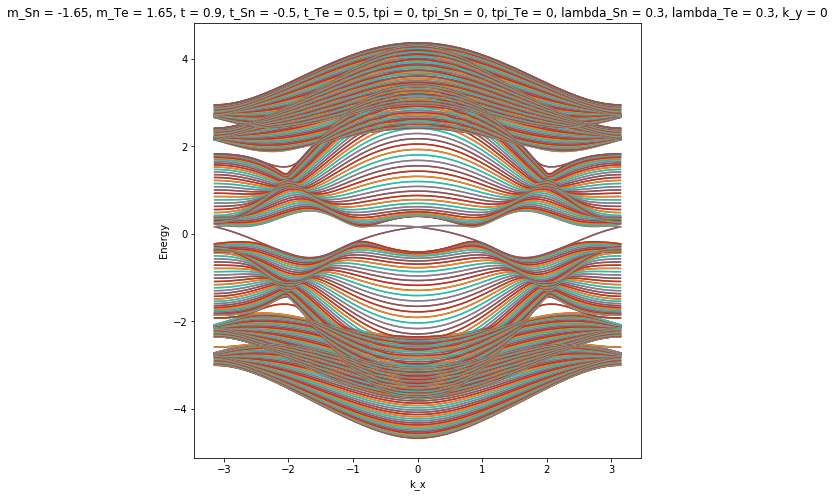

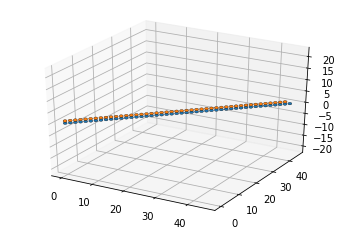

Wall time: 7.89 s


In [76]:
%%time

param_test = dict(
    m_Sn = -1.65, 
    m_Te = 1.65,
    t = 0.9, 
    t_Sn = -0.5, 
    t_Te = 0.5,
    tpi = 0,
    tpi_Sn = 0,
    tpi_Te = 0,
    lambda_Sn = 0.3, 
    lambda_Te = 0.3, 
    k_y = 0)

param_test_inv = dict(
    m_Sn = 1.65, 
    m_Te = -1.65,
    t = 0.9, 
    t_Sn = 0.5, 
    t_Te = -0.5,
    tpi = 0,
    tpi_Sn = 0,
    tpi_Te = 0,
    lambda_Sn = 0.3, 
    lambda_Te = 0.3, 
    k_y = 0)


kwant.plot(Slab111(H = 91, param = param_test))
plt.show()

### Observations
For $H=20$, we note that surface states tend to emerge when $t_{Sn} \approx -t_{Te}$, i.e. they should be of opposite sign and similar to each other in absolute sense. The same goes for the masses: $m_{Sn} \approx -m_{Te}$.
Addition of nn- and nnn-$\pi$-hopping does not influence the opening of the surface states, nor the change of sign for all hopping amplitudes.

In [6]:
ham_mass = ("-m * kron(sigma_z, eye(3))")
ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0],[0, cos(k_y)]]))")
ham_nnn = ("2*t_Sn*kron(sigma_z, Matrix([[cos(k_x)*(cos(k_y)), -sin(k_x)*sin(k_y)],[-sin(k_y)*sin(k_x), cos(k_y)*cos(k_x)]]))")
ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +")"
H = qsymm.Model(ham_nn)
H.tosympy(nsimplify=True)

Matrix([
[                           0,                            0, e**(I*k_x)*t + e**(-I*k_x)*t,                            0],
[                           0,                            0,                            0, e**(I*k_y)*t + e**(-I*k_y)*t],
[e**(I*k_x)*t + e**(-I*k_x)*t,                            0,                            0,                            0],
[                           0, e**(I*k_y)*t + e**(-I*k_y)*t,                            0,                            0]])

In [7]:
hamiltonian = """
       + C * identity(4) + M * kron(sigma_0, sigma_z)
       - B * (k_x**2 + k_y**2) * kron(sigma_0, sigma_z)
       - D * (k_x**2 + k_y**2) * kron(sigma_0, sigma_0)
       + A * k_x * kron(sigma_z, sigma_x)
       - A * k_y * kron(sigma_0, sigma_y)
    """
H = qsymm.Model(hamiltonian)
H.tosympy(nsimplify=True)

Matrix([
[-B*k_x**2 - B*k_y**2 + C - D*k_x**2 - D*k_y**2 + M,                                   A*k_x + I*A*k_y,                                                  0,                                                 0],
[                                   A*k_x - I*A*k_y, B*k_x**2 + B*k_y**2 + C - D*k_x**2 - D*k_y**2 - M,                                                  0,                                                 0],
[                                                 0,                                                 0, -B*k_x**2 - B*k_y**2 + C - D*k_x**2 - D*k_y**2 + M,                                  -A*k_x + I*A*k_y],
[                                                 0,                                                 0,                                   -A*k_x - I*A*k_y, B*k_x**2 + B*k_y**2 + C - D*k_x**2 - D*k_y**2 - M]])

In [8]:
ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, -t_Sn]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
ham_nnpi = ("-2*t^pi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
ham_nnnpi = ("-2*kron(Matrix([[t^pi_Sn, 0],[0, t^pi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
ham_ = "kron(" + ham + ", eye(2))"
soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
Ham = "(" + ham_ +" + " + soi +")"
H = qsymm.Model(ham_nnn)
H.tosympy(nsimplify=True)

Matrix([
[e**(I*k_x)*e**(I*k_y)*t_Sn/2 + e**(I*k_x)*e**(I*k_z)*t_Sn/2 + e**(I*k_x)*e**(-I*k_z)*t_Sn/2 + e**(I*k_x)*e**(-I*k_y)*t_Sn/2 + e**(-I*k_x)*e**(I*k_y)*t_Sn/2 + e**(-I*k_x)*e**(I*k_z)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_z)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_y)*t_Sn/2,                                                                                                                                 e**(I*k_x)*e**(I*k_y)*t_Sn/2 - e**(I*k_x)*e**(-I*k_y)*t_Sn/2 - e**(-I*k_x)*e**(I*k_y)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_y)*t_Sn/2,                                                                                                                                 e**(I*k_x)*e**(I*k_z)*t_Sn/2 - e**(I*k_x)*e**(-I*k_z)*t_Sn/2 - e**(-I*k_x)*e**(I*k_z)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_z)*t_Sn/2,                                                                                                                                                                                                                                  

In [9]:
ham_nnpi = ("-2*t^pi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
H = qsymm.Model(ham_nnpi)
H.tosympy(nsimplify=True)

Matrix([
[                                                                           0,                                                                            0,                                                                            0, -e**(I*k_y)*t**pi - e**(I*k_z)*t**pi - e**(-I*k_z)*t**pi - e**(-I*k_y)*t**pi,                                                                            0,                                                                            0],
[                                                                           0,                                                                            0,                                                                            0,                                                                            0, -e**(I*k_x)*t**pi - e**(I*k_z)*t**pi - e**(-I*k_z)*t**pi - e**(-I*k_x)*t**pi,                                                                            0],
[                                                  